Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.6 MB/s 
     |████████████████████████████████| 6.6 MB 79.8 MB/s 
     |████████████████████████████████| 120 kB 83.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=67b0525cc6ea0c77467b2188536e964ddc6c6cd2280da72fa3bd714ca5bc80f5
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['I-AGMT_DATE', 'I-PARTY', 'B-PARTY', 'I-DOC_NAME', 'O', 'B-DOC_NAME', 'B-AGMT_DATE']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-AGMT_DATE', 'I-PARTY', 'B-PARTY', 'I-DOC_NAME', 'O', 'B-DOC_NAME', 'B-AGMT_DATE']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-AGMT_DATE', 'I-PARTY', 'B-PARTY', 'I-DOC_NAME', 'O', 'B-DOC_NAME', 'B-AGMT_DATE']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

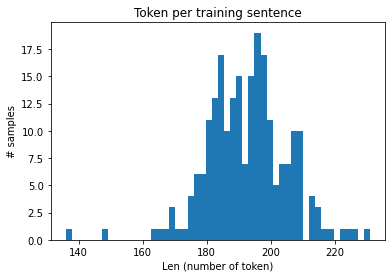

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

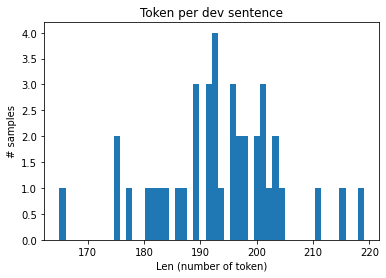

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

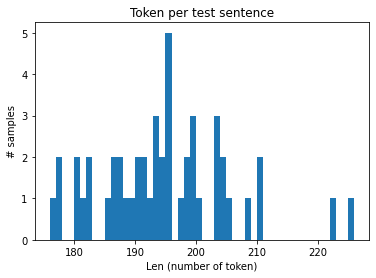

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

2926
BIOCEPT
2
B-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 226
Points in y_train before removal: 226


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

NameError: ignored

In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 13.6 MB/s 
     |████████████████████████████████| 6.6 MB 75.5 MB/s 
     |████████████████████████████████| 120 kB 84.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=58f1e40174e06ec0cc5915e44b2bb21e77bd7ce18dab63e575fdcd270b557c00
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[4696, 6573, 1251, 477, 4439, 5724, 3491, 5780, 5261, 6633

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  print(maxlen)

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0949573516845703
Training loss epoch: 0.4565664955547878
Training accuracy epoch: 0.8590343941099815
Validating model...
Validation Loss: 0.15679403021931648
Validation Accuracy: 0.9531020781539309
Training epoch: 2
Training loss per 100 training steps: 0.20559825003147125
Training loss epoch: 0.12593371208224977
Training accuracy epoch: 0.9602579772093691
Validating model...
Validation Loss: 0.07898045983165503
Validation Accuracy: 0.9785906540659808
Training epoch: 3
Training loss per 100 training steps: 0.0730852335691452
Training loss epoch: 0.06132573935957182
Training accuracy epoch: 0.9838953795831044
Validating model...
Validation Loss: 0.081229692324996
Validation Accuracy: 0.9764502811841256
Training epoch: 4
Training loss per 100 training steps: 0.0407051220536232
Training loss epoch: 0.03853770460756052
Training accuracy epoch: 0.9900073120582746
Validating model...
Validation Loss: 0.06875834427773952
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06286133341491222
Validation Accuracy: 0.986483295001395
Validation duration: 0.008063700000000059 minutes
F1-score (test): 88.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.94      0.93        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.84      0.88      0.86       122

   micro avg       0.87      0.90      0.88       254
   macro avg       0.88      0.91      0.89       254
weighted avg       0.87      0.90      0.88       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9053953886032104
Training loss epoch: 0.5414205782470249
Training accuracy epoch: 0.8461338125735742
Validating model...
Validation Loss: 0.2158682942390442
Validation Accuracy: 0.9296476140332335
Training epoch: 2
Training loss per 100 training steps: 0.254271537065506
Training loss epoch: 0.14527075258748873
Training accuracy epoch: 0.9557294635621804
Validating model...
Validation Loss: 0.10165453888475895
Validation Accuracy: 0.9712080199602005
Training epoch: 3
Training loss per 100 training steps: 0.07527898997068405
Training loss epoch: 0.06845480984165556
Training accuracy epoch: 0.9822000179621606
Validating model...
Validation Loss: 0.07704360410571098
Validation Accuracy: 0.977525330151904
Training epoch: 4
Training loss per 100 training steps: 0.05176535248756409
Training loss epoch: 0.04875598333421208
Training accuracy epoch: 0.9872334781904955
Validating model...
Validation Loss: 0.09684251621365547
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.056871086731553076
Validation Accuracy: 0.9849102772356894
Validation duration: 0.008042400000000309 minutes
F1-score (test): 88.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.93      0.94      0.93        82
       PARTY       0.81      0.90      0.86       122

   micro avg       0.86      0.91      0.88       254
   macro avg       0.87      0.91      0.89       254
weighted avg       0.86      0.91      0.88       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.061293363571167
Training loss epoch: 0.47936695459343137
Training accuracy epoch: 0.8544763343343584
Validating model...
Validation Loss: 0.1760314144194126
Validation Accuracy: 0.939345464757869
Training epoch: 2
Training loss per 100 training steps: 0.23560023307800293
Training loss epoch: 0.1373785888510091
Training accuracy epoch: 0.9561268014464265
Validating model...
Validation Loss: 0.09436509758234024
Validation Accuracy: 0.9712593251936188
Training epoch: 3
Training loss per 100 training steps: 0.07685119658708572
Training loss epoch: 0.07062972390225955
Training accuracy epoch: 0.9810588387434189
Validating model...
Validation Loss: 0.0740782767534256
Validation Accuracy: 0.9753446053697465
Training epoch: 4
Training loss per 100 training steps: 0.06893578916788101
Training loss epoch: 0.0395076365343162
Training accuracy epoch: 0.9894279265878337
Validating model...
Validation Loss: 0.07484940439462662
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0742067500948906
Validation Accuracy: 0.9818649019756226
Validation duration: 0.008049283333333317 minutes
F1-score (test): 85.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.88      0.90        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.74      0.87      0.80       122

   micro avg       0.82      0.89      0.85       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.82      0.89      0.85       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.922154426574707
Training loss epoch: 0.4509700983762741
Training accuracy epoch: 0.8620257173859026
Validating model...
Validation Loss: 0.15307846292853355
Validation Accuracy: 0.9561369496804968
Training epoch: 2
Training loss per 100 training steps: 0.1994362473487854
Training loss epoch: 0.12226753114234834
Training accuracy epoch: 0.9618803498688124
Validating model...
Validation Loss: 0.09710577130317688
Validation Accuracy: 0.9719623315778428
Training epoch: 3
Training loss per 100 training steps: 0.04479270800948143
Training loss epoch: 0.06281992686646325
Training accuracy epoch: 0.982959169369835
Validating model...
Validation Loss: 0.07541751116514206
Validation Accuracy: 0.9795246112257238
Training epoch: 4
Training loss per 100 training steps: 0.06288737058639526
Training loss epoch: 0.03954431086423851
Training accuracy epoch: 0.9890603088855305
Validating model...
Validation Loss: 0.07800432946532965
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07077030465006828
Validation Accuracy: 0.9835902838170789
Validation duration: 0.009756983333333361 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.84      0.85        50
    DOC_NAME       0.88      0.95      0.91        82
       PARTY       0.79      0.88      0.83       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.84      0.89      0.86       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0436532497406006
Training loss epoch: 0.45041470300583614
Training accuracy epoch: 0.8595504909920331
Validating model...
Validation Loss: 0.1514621004462242
Validation Accuracy: 0.9562975375672496
Training epoch: 2
Training loss per 100 training steps: 0.1304987072944641
Training loss epoch: 0.1288095670086997
Training accuracy epoch: 0.9620852397322669
Validating model...
Validation Loss: 0.07920281402766705
Validation Accuracy: 0.9770183357106487
Training epoch: 3
Training loss per 100 training steps: 0.06031535938382149
Training loss epoch: 0.05858692961434523
Training accuracy epoch: 0.9838190232593071
Validating model...
Validation Loss: 0.06785826524719596
Validation Accuracy: 0.9812875551245541
Training epoch: 4
Training loss per 100 training steps: 0.01542747300118208
Training loss epoch: 0.04047094928544192
Training accuracy epoch: 0.9896560613854254
Validating model...
Validation Loss: 0.06570895295590162
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.057925859838724135
Validation Accuracy: 0.9839871006767918
Validation duration: 0.00842245000000048 minutes
F1-score (test): 83.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.79      0.88      0.83        82
       PARTY       0.78      0.88      0.83       122

   micro avg       0.80      0.88      0.84       254
   macro avg       0.81      0.88      0.84       254
weighted avg       0.80      0.88      0.84       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9679352045059204
Training loss epoch: 0.4463943409777823
Training accuracy epoch: 0.8616467108503967
Validating model...
Validation Loss: 0.17320874705910683
Validation Accuracy: 0.9452262406438826
Training epoch: 2
Training loss per 100 training steps: 0.21988624334335327
Training loss epoch: 0.12266502068156288
Training accuracy epoch: 0.9614634361320762
Validating model...
Validation Loss: 0.10637303814291954
Validation Accuracy: 0.9693811333785692
Training epoch: 3
Training loss per 100 training steps: 0.07959847897291183
Training loss epoch: 0.06171436829581147
Training accuracy epoch: 0.9841400692133294
Validating model...
Validation Loss: 0.07344664633274078
Validation Accuracy: 0.9814853110211648
Training epoch: 4
Training loss per 100 training steps: 0.06887956708669662
Training loss epoch: 0.04027138508501507
Training accuracy epoch: 0.988783168556808
Validating model...
Validation Loss: 0.058837099466472864
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.053936274349689485
Validation Accuracy: 0.9854168278009909
Validation duration: 0.008088933333333633 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.77      0.84      0.81       122

   micro avg       0.82      0.88      0.85       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.82      0.88      0.85       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0191714763641357
Training loss epoch: 0.5546662991955167
Training accuracy epoch: 0.844111065298787
Validating model...
Validation Loss: 0.18983599171042442
Validation Accuracy: 0.9381121788714218
Training epoch: 2
Training loss per 100 training steps: 0.18098880350589752
Training loss epoch: 0.14509453535789535
Training accuracy epoch: 0.9540171433040786
Validating model...
Validation Loss: 0.08623075671494007
Validation Accuracy: 0.9739232429207803
Training epoch: 3
Training loss per 100 training steps: 0.07693509757518768
Training loss epoch: 0.06696074784156822
Training accuracy epoch: 0.9814381263713249
Validating model...
Validation Loss: 0.07634277269244194
Validation Accuracy: 0.9787718833781294
Training epoch: 4
Training loss per 100 training steps: 0.052169349044561386
Training loss epoch: 0.04061582285378661
Training accuracy epoch: 0.9885006503958284
Validating model...
Validation Loss: 0.06979836989194155
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06347174271941185
Validation Accuracy: 0.9860837018273306
Validation duration: 0.009625216666665892 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.86      0.89      0.87        82
       PARTY       0.80      0.90      0.85       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.148463726043701
Training loss epoch: 0.5425540982257753
Training accuracy epoch: 0.8433535702579427
Validating model...
Validation Loss: 0.18292733281850815
Validation Accuracy: 0.9406235207830504
Training epoch: 2
Training loss per 100 training steps: 0.1408005654811859
Training loss epoch: 0.14725499422777266
Training accuracy epoch: 0.9541672590846462
Validating model...
Validation Loss: 0.1147928535938263
Validation Accuracy: 0.9660092890349343
Training epoch: 3
Training loss per 100 training steps: 0.07835578173398972
Training loss epoch: 0.07861883157775515
Training accuracy epoch: 0.9777427048817581
Validating model...
Validation Loss: 0.07106996886432171
Validation Accuracy: 0.9805961697564699
Training epoch: 4
Training loss per 100 training steps: 0.0679292157292366
Training loss epoch: 0.04498837409274919
Training accuracy epoch: 0.9883320435461992
Validating model...
Validation Loss: 0.07847199961543083
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07967161908745765
Validation Accuracy: 0.9817703411160172
Validation duration: 0.008109266666666788 minutes
F1-score (test): 81.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.88      0.90        50
    DOC_NAME       0.81      0.83      0.82        82
       PARTY       0.75      0.83      0.79       122

   micro avg       0.80      0.84      0.82       254
   macro avg       0.83      0.85      0.84       254
weighted avg       0.80      0.84      0.82       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.958411455154419
Training loss epoch: 0.4727322877872558
Training accuracy epoch: 0.8585653729366145
Validating model...
Validation Loss: 0.16366365924477577
Validation Accuracy: 0.9493594238947133
Training epoch: 2
Training loss per 100 training steps: 0.1684819459915161
Training loss epoch: 0.1224044490428198
Training accuracy epoch: 0.962944618062435
Validating model...
Validation Loss: 0.08201725594699383
Validation Accuracy: 0.9774177263089746
Training epoch: 3
Training loss per 100 training steps: 0.05759785696864128
Training loss epoch: 0.06034977450257256
Training accuracy epoch: 0.983512002629532
Validating model...
Validation Loss: 0.06767226569354534
Validation Accuracy: 0.9781137107937241
Training epoch: 4
Training loss per 100 training steps: 0.04362206906080246
Training loss epoch: 0.035695571097589675
Training accuracy epoch: 0.9907582294986826
Validating model...
Validation Loss: 0.06739151664078236
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06034997068345547
Validation Accuracy: 0.9857960192706058
Validation duration: 0.008113166666666416 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.88      0.89        50
    DOC_NAME       0.88      0.95      0.91        82
       PARTY       0.79      0.86      0.82       122

   micro avg       0.84      0.89      0.86       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.84      0.89      0.87       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 226
Points in y_train after augmentation: 226
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.912666916847229
Training loss epoch: 0.5287334840922129
Training accuracy epoch: 0.8544762486460784
Validating model...
Validation Loss: 0.18641949072480202
Validation Accuracy: 0.9379776386696739
Training epoch: 2
Training loss per 100 training steps: 0.20572707056999207
Training loss epoch: 0.13139735836358296
Training accuracy epoch: 0.9593034157727421
Validating model...
Validation Loss: 0.08744846470654011
Validation Accuracy: 0.976311392761101
Training epoch: 3
Training loss per 100 training steps: 0.07329162955284119
Training loss epoch: 0.06274876495202382
Training accuracy epoch: 0.9826994907219183
Validating model...
Validation Loss: 0.06981466803699732
Validation Accuracy: 0.9809982746079468
Training epoch: 4
Training loss per 100 training steps: 0.04669471085071564
Training loss epoch: 0.04127295049173491
Training accuracy epoch: 0.9892315110726922
Validating model...
Validation Loss: 0.07416451489552855
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08115630149841309
Validation Accuracy: 0.9851243446755873
Validation duration: 0.009692316666667011 minutes
F1-score (test): 89.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.94      0.94      0.94        50
    DOC_NAME       0.92      0.95      0.93        82
       PARTY       0.81      0.90      0.85       122

   micro avg       0.87      0.93      0.90       254
   macro avg       0.89      0.93      0.91       254
weighted avg       0.87      0.93      0.90       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0971333980560303
Training loss epoch: 0.5322799207199187
Training accuracy epoch: 0.8523464492971491
Validating model...
Validation Loss: 0.19046975299715996
Validation Accuracy: 0.9365745873892378
Training epoch: 2
Training loss per 100 training steps: 0.2316863089799881
Training loss epoch: 0.15563324980792545
Training accuracy epoch: 0.9493467450322373
Validating model...
Validation Loss: 0.10303671658039093
Validation Accuracy: 0.9704260317530208
Training epoch: 3
Training loss per 100 training steps: 0.12757939100265503
Training loss epoch: 0.07676803551259495
Training accuracy epoch: 0.9778220963719475
Validating model...
Validation Loss: 0.07472212519496679
Validation Accuracy: 0.9809679979854318
Training epoch: 4
Training loss per 100 training steps: 0.05041016638278961
Training loss epoch: 0.04360818658911046
Training accuracy epoch: 0.9885950348916229
Validating model...
Validation Loss: 0.07122768554836512
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06972369961440564
Validation Accuracy: 0.984138175909137
Validation duration: 0.00812423333333451 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.87      0.90      0.89        82
       PARTY       0.80      0.90      0.85       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.84      0.89      0.86       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1331677436828613
Training loss epoch: 0.5066482992399306
Training accuracy epoch: 0.8551152874975143
Validating model...
Validation Loss: 0.1692107655107975
Validation Accuracy: 0.9334612272986818
Training epoch: 2
Training loss per 100 training steps: 0.1958816647529602
Training loss epoch: 0.13126589003063382
Training accuracy epoch: 0.9584673876138611
Validating model...
Validation Loss: 0.09821701049804688
Validation Accuracy: 0.967645395993635
Training epoch: 3
Training loss per 100 training steps: 0.08940219134092331
Training loss epoch: 0.08094956991927964
Training accuracy epoch: 0.9759678317652952
Validating model...
Validation Loss: 0.07622265443205833
Validation Accuracy: 0.97907761956375
Training epoch: 4
Training loss per 100 training steps: 0.06754335761070251
Training loss epoch: 0.058372397596637406
Training accuracy epoch: 0.9830651088404381
Validating model...
Validation Loss: 0.0714413383975625
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06239348985254765
Validation Accuracy: 0.9849665615703703
Validation duration: 0.009830933333334239 minutes
F1-score (test): 87.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.92      0.89        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.82      0.88      0.85       122

   micro avg       0.85      0.90      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9093211889266968
Training loss epoch: 0.4515439676386969
Training accuracy epoch: 0.8674604299973142
Validating model...
Validation Loss: 0.17758774757385254
Validation Accuracy: 0.9426915091061121
Training epoch: 2
Training loss per 100 training steps: 0.15818174183368683
Training loss epoch: 0.12726985130991256
Training accuracy epoch: 0.9613018709751786
Validating model...
Validation Loss: 0.10965532250702381
Validation Accuracy: 0.966783995018137
Training epoch: 3
Training loss per 100 training steps: 0.11479046940803528
Training loss epoch: 0.06950754698898111
Training accuracy epoch: 0.9803077440717884
Validating model...
Validation Loss: 0.07644615788012743
Validation Accuracy: 0.9760732380884616
Training epoch: 4
Training loss per 100 training steps: 0.052238915115594864
Training loss epoch: 0.047343534018312185
Training accuracy epoch: 0.9867921324841095
Validating model...
Validation Loss: 0.07461830414831638
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06187333799898624
Validation Accuracy: 0.9829483451449118
Validation duration: 0.008091833333332943 minutes
F1-score (test): 86.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.92      0.89        50
    DOC_NAME       0.91      0.95      0.93        82
       PARTY       0.76      0.85      0.81       122

   micro avg       0.83      0.90      0.86       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.90      0.86       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8016297817230225
Training loss epoch: 0.45133950880595614
Training accuracy epoch: 0.8724586154206387
Validating model...
Validation Loss: 0.16045848280191422
Validation Accuracy: 0.9482530065035445
Training epoch: 2
Training loss per 100 training steps: 0.13793633878231049
Training loss epoch: 0.13162500269356228
Training accuracy epoch: 0.9589991562930869
Validating model...
Validation Loss: 0.1037194225937128
Validation Accuracy: 0.9692678708744386
Training epoch: 3
Training loss per 100 training steps: 0.08312518149614334
Training loss epoch: 0.0770283362695149
Training accuracy epoch: 0.9772153111471763
Validating model...
Validation Loss: 0.0773726450279355
Validation Accuracy: 0.976565985238875
Training epoch: 4
Training loss per 100 training steps: 0.04088982939720154
Training loss epoch: 0.04560578029070582
Training accuracy epoch: 0.986891416719291
Validating model...
Validation Loss: 0.08218896854668856
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06284917369484902
Validation Accuracy: 0.9840059423048275
Validation duration: 0.00819515000000024 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.85      0.90      0.88        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.82      0.89      0.85       254
   macro avg       0.84      0.89      0.87       254
weighted avg       0.82      0.89      0.85       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231
Device:  cuda

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.827589988708496
Training loss epoch: 0.46018646231719423
Training accuracy epoch: 0.8679729409143329
Validating model...
Validation Loss: 0.17364012077450752
Validation Accuracy: 0.9431555758872626
Training epoch: 2
Training loss per 100 training steps: 0.1949702799320221
Training loss epoch: 0.12589318411690847
Training accuracy epoch: 0.9614564000588652
Validating model...
Validation Loss: 0.09235069900751114
Validation Accuracy: 0.9721306176487398
Training epoch: 3
Training loss per 100 training steps: 0.09121301770210266
Training loss epoch: 0.06129474920176324
Training accuracy epoch: 0.9836703327292151
Validating model...
Validation Loss: 0.06271898746490479
Validation Accuracy: 0.981696440650508
Training epoch: 4
Training loss per 100 training steps: 0.05646052584052086
Training loss epoch: 0.03815129119902849
Training accuracy epoch: 0.9895465565816843
Validating model...
Validation Loss: 0.06184855103492737
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.057837709039449695
Validation Accuracy: 0.9833528134049987
Validation duration: 0.009702300000001666 minutes
F1-score (test): 86.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.84      0.82        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.82      0.89      0.85       122

   micro avg       0.84      0.89      0.87       254
   macro avg       0.84      0.88      0.86       254
weighted avg       0.84      0.89      0.87       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2623603343963623
Training loss epoch: 0.5251762540567488
Training accuracy epoch: 0.8506323181455374
Validating model...
Validation Loss: 0.170819204300642
Validation Accuracy: 0.9370345891443197
Training epoch: 2
Training loss per 100 training steps: 0.2002658098936081
Training loss epoch: 0.14311164227269946
Training accuracy epoch: 0.9584086786686798
Validating model...
Validation Loss: 0.09791061468422413
Validation Accuracy: 0.9727749464478145
Training epoch: 3
Training loss per 100 training steps: 0.1300373524427414
Training loss epoch: 0.08013678448540824
Training accuracy epoch: 0.9779253061409486
Validating model...
Validation Loss: 0.07397202495485544
Validation Accuracy: 0.9801872699935518
Training epoch: 4
Training loss per 100 training steps: 0.03901268541812897
Training loss epoch: 0.046643653485391824
Training accuracy epoch: 0.9878137921247659
Validating model...
Validation Loss: 0.07024371530860662
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06658076494932175
Validation Accuracy: 0.9830004765770999
Validation duration: 0.00804701666666574 minutes
F1-score (test): 85.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.89      0.90      0.90        82
       PARTY       0.76      0.86      0.80       122

   micro avg       0.82      0.88      0.85       254
   macro avg       0.84      0.89      0.86       254
weighted avg       0.82      0.88      0.85       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Device:  cuda
Training epoch: 1
Training loss per 100 training steps: 1.94544517993927
Training loss epoch: 0.5122856426806677
Training accuracy epoch: 0.8553863073222868
Validating model...
Validation Loss: 0.16779275983572006
Validation Accuracy: 0.9403035013677777
Training epoch: 2
Training loss per 100 training steps: 0.20288921892642975
Training loss epoch: 0.14037324771994636
Training accuracy epoch: 0.9528947067497071
Validating model...
Validation Loss: 0.10309537313878536
Validation Accuracy: 0.9719059552566613
Training epoch: 3
Training loss per 100 training steps: 0.09488308429718018
Training loss epoch: 0.0780000150913284
Training accuracy epoch: 0.9767502581018612
Validating model...
Validation Loss: 0.06602950301021338
Validation Accuracy: 0.9820171838614393
Training epoch: 4
Training loss per 100 training steps: 0.04423891007900238
Training loss epoch: 0.04407805461613905
Training accuracy epoch: 0.9880853021446582
Validating model...
Validation Loss: 0.06387559603899717

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07512231841683388
Validation Accuracy: 0.9826985991159469
Validation duration: 0.008162433333332804 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.75      0.89      0.81       122

   micro avg       0.81      0.90      0.85       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.82      0.90      0.85       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.131309986114502
Training loss epoch: 0.5106468519994191
Training accuracy epoch: 0.850782156915733
Validating model...
Validation Loss: 0.18564803525805473
Validation Accuracy: 0.9362255229742861
Training epoch: 2
Training loss per 100 training steps: 0.24918816983699799
Training loss epoch: 0.15788548368783223
Training accuracy epoch: 0.9497698963142825
Validating model...
Validation Loss: 0.10708405449986458
Validation Accuracy: 0.9687191685042368
Training epoch: 3
Training loss per 100 training steps: 0.07536488026380539
Training loss epoch: 0.08069132499042012
Training accuracy epoch: 0.9759251738784697
Validating model...
Validation Loss: 0.08166887052357197
Validation Accuracy: 0.9764324823202208
Training epoch: 4
Training loss per 100 training steps: 0.04831869155168533
Training loss epoch: 0.05490654875479993
Training accuracy epoch: 0.9846524242303306
Validating model...
Validation Loss: 0.07021249178797007
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07121092528104782
Validation Accuracy: 0.9816307270311768
Validation duration: 0.009686849999998989 minutes
F1-score (test): 84.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.76      0.87      0.81       122

   micro avg       0.81      0.89      0.85       254
   macro avg       0.82      0.89      0.85       254
weighted avg       0.81      0.89      0.85       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0908169746398926
Training loss epoch: 0.48535549569697606
Training accuracy epoch: 0.8562500208046382
Validating model...
Validation Loss: 0.1646827571094036
Validation Accuracy: 0.9379741063580203
Training epoch: 2
Training loss per 100 training steps: 0.18752440810203552
Training loss epoch: 0.13579258287236803
Training accuracy epoch: 0.9561344033641908
Validating model...
Validation Loss: 0.09045296721160412
Validation Accuracy: 0.9758100961491127
Training epoch: 3
Training loss per 100 training steps: 0.06007177010178566
Training loss epoch: 0.07522044543709074
Training accuracy epoch: 0.9783491015234848
Validating model...
Validation Loss: 0.06893404759466648
Validation Accuracy: 0.9791296486573455
Training epoch: 4
Training loss per 100 training steps: 0.05740395188331604
Training loss epoch: 0.04216986158419223
Training accuracy epoch: 0.9885749385706555
Validating model...
Validation Loss: 0.07963085174560547
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05357307568192482
Validation Accuracy: 0.9839582910287673
Validation duration: 0.008119500000001759 minutes
F1-score (test): 83.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.86      0.87        50
    DOC_NAME       0.86      0.89      0.87        82
       PARTY       0.74      0.86      0.80       122

   micro avg       0.80      0.87      0.84       254
   macro avg       0.83      0.87      0.85       254
weighted avg       0.81      0.87      0.84       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.971343994140625
Training loss epoch: 0.5030891036703473
Training accuracy epoch: 0.8558954663974427
Validating model...
Validation Loss: 0.18300995975732803
Validation Accuracy: 0.9356706061896553
Training epoch: 2
Training loss per 100 training steps: 0.17017759382724762
Training loss epoch: 0.1575335001661664
Training accuracy epoch: 0.9482504631242651
Validating model...
Validation Loss: 0.10747894272208214
Validation Accuracy: 0.9715661898019209
Training epoch: 3
Training loss per 100 training steps: 0.1022220328450203
Training loss epoch: 0.0870891972666695
Training accuracy epoch: 0.9750349332046143
Validating model...
Validation Loss: 0.06690727826207876
Validation Accuracy: 0.9808004588253021
Training epoch: 4
Training loss per 100 training steps: 0.05922595039010048
Training loss epoch: 0.047666998846190314
Training accuracy epoch: 0.9869308841771466
Validating model...
Validation Loss: 0.07831387221813202
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.058111505955457686
Validation Accuracy: 0.9837565934238475
Validation duration: 0.00807516666666667 minutes
F1-score (test): 84.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.82      0.87      0.84        82
       PARTY       0.77      0.88      0.82       122

   micro avg       0.81      0.88      0.84       254
   macro avg       0.82      0.88      0.85       254
weighted avg       0.81      0.88      0.84       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1918342113494873
Training loss epoch: 0.5156964124603705
Training accuracy epoch: 0.8559918948281474
Validating model...
Validation Loss: 0.18593363463878632
Validation Accuracy: 0.9359680602268754
Training epoch: 2
Training loss per 100 training steps: 0.19051745533943176
Training loss epoch: 0.1406607133421031
Training accuracy epoch: 0.9557931527049692
Validating model...
Validation Loss: 0.09678555466234684
Validation Accuracy: 0.9723638841448392
Training epoch: 3
Training loss per 100 training steps: 0.08285805583000183
Training loss epoch: 0.06921917420219291
Training accuracy epoch: 0.980287440523873
Validating model...
Validation Loss: 0.07015069760382175
Validation Accuracy: 0.980195175479128
Training epoch: 4
Training loss per 100 training steps: 0.044160276651382446
Training loss epoch: 0.039925883947448296
Training accuracy epoch: 0.9887783067215993
Validating model...
Validation Loss: 0.06883090548217297
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06178328655660152
Validation Accuracy: 0.9831307458279636
Validation duration: 0.009657266666666449 minutes
F1-score (test): 86.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.80      0.86      0.83       122

   micro avg       0.84      0.89      0.86       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.84      0.89      0.86       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0078465938568115
Training loss epoch: 0.45264472744681616
Training accuracy epoch: 0.8666875408840564
Validating model...
Validation Loss: 0.18930917978286743
Validation Accuracy: 0.937469373665369
Training epoch: 2
Training loss per 100 training steps: 0.14993327856063843
Training loss epoch: 0.13175080242482098
Training accuracy epoch: 0.9557124588286684
Validating model...
Validation Loss: 0.13132060505449772
Validation Accuracy: 0.9642222915441738
Training epoch: 3
Training loss per 100 training steps: 0.07386109232902527
Training loss epoch: 0.07080045240846547
Training accuracy epoch: 0.9791154081526348
Validating model...
Validation Loss: 0.07331690564751625
Validation Accuracy: 0.9764843979479154
Training epoch: 4
Training loss per 100 training steps: 0.03563295304775238
Training loss epoch: 0.04499868354336782
Training accuracy epoch: 0.9877938783402326
Validating model...
Validation Loss: 0.06986349541693926
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.060789409279823306
Validation Accuracy: 0.9842822120948597
Validation duration: 0.00963253333333493 minutes
F1-score (test): 85.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.77      0.85      0.81       122

   micro avg       0.83      0.88      0.85       254
   macro avg       0.84      0.88      0.86       254
weighted avg       0.83      0.88      0.85       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9730875492095947
Training loss epoch: 0.5065302659164775
Training accuracy epoch: 0.8594865959148269
Validating model...
Validation Loss: 0.18451478332281113
Validation Accuracy: 0.9366954718028375
Training epoch: 2
Training loss per 100 training steps: 0.17352965474128723
Training loss epoch: 0.14585737680846994
Training accuracy epoch: 0.9522513569839355
Validating model...
Validation Loss: 0.10070191510021687
Validation Accuracy: 0.9698706755569966
Training epoch: 3
Training loss per 100 training steps: 0.07399836927652359
Training loss epoch: 0.07091696458784016
Training accuracy epoch: 0.9790896038356439
Validating model...
Validation Loss: 0.074661317281425
Validation Accuracy: 0.9766126973815811
Training epoch: 4
Training loss per 100 training steps: 0.05342232063412666
Training loss epoch: 0.04162527980621566
Training accuracy epoch: 0.9884776154730951
Validating model...
Validation Loss: 0.07622364722192287
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07161018326878547
Validation Accuracy: 0.9816214793391081
Validation duration: 0.00809476666666645 minutes
F1-score (test): 83.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.82      0.85        50
    DOC_NAME       0.84      0.90      0.87        82
       PARTY       0.78      0.84      0.81       122

   micro avg       0.82      0.86      0.84       254
   macro avg       0.84      0.86      0.85       254
weighted avg       0.82      0.86      0.84       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 339

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9451037645339966
Training loss epoch: 0.5043926259333437
Training accuracy epoch: 0.8631223402077484
Validating model...
Validation Loss: 0.18182087317109108
Validation Accuracy: 0.9357458363495453
Training epoch: 2
Training loss per 100 training steps: 0.18547959625720978
Training loss epoch: 0.14382821236821738
Training accuracy epoch: 0.9539945994494663
Validating model...
Validation Loss: 0.08592189662158489
Validation Accuracy: 0.973012561834292
Training epoch: 3
Training loss per 100 training steps: 0.05809573829174042
Training loss epoch: 0.06395806558430195
Training accuracy epoch: 0.9821607550895798
Validating model...
Validation Loss: 0.07136352267116308
Validation Accuracy: 0.9799186078611006
Training epoch: 4
Training loss per 100 training steps: 0.04934031888842583
Training loss epoch: 0.04220768462189219
Training accuracy epoch: 0.988945511076886
Validating model...
Validation Loss: 0.08310877345502377
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07089083567261696
Validation Accuracy: 0.9792751208621148
Validation duration: 0.008006466666669591 minutes
F1-score (test): 82.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.86      0.83        50
    DOC_NAME       0.86      0.93      0.89        82
       PARTY       0.70      0.88      0.78       122

   micro avg       0.77      0.89      0.83       254
   macro avg       0.79      0.89      0.84       254
weighted avg       0.78      0.89      0.83       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.099447250366211
Training loss epoch: 0.535365803675218
Training accuracy epoch: 0.852420399333127
Validating model...
Validation Loss: 0.19901060685515404
Validation Accuracy: 0.9309848466386423
Training epoch: 2
Training loss per 100 training steps: 0.26729297637939453
Training loss epoch: 0.14302169328386133
Training accuracy epoch: 0.9558278200928023
Validating model...
Validation Loss: 0.09447518549859524
Validation Accuracy: 0.9738562571988991
Training epoch: 3
Training loss per 100 training steps: 0.08497007191181183
Training loss epoch: 0.06760414791378108
Training accuracy epoch: 0.9812905327883271
Validating model...
Validation Loss: 0.0753827914595604
Validation Accuracy: 0.9775822660022989
Training epoch: 4
Training loss per 100 training steps: 0.055798545479774475
Training loss epoch: 0.04734523653645407
Training accuracy epoch: 0.9863184806642544
Validating model...
Validation Loss: 0.07420787028968334
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06333905309438706
Validation Accuracy: 0.9862031314318447
Validation duration: 0.008113683333332726 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.86      0.91      0.89        82
       PARTY       0.77      0.89      0.82       122

   micro avg       0.82      0.90      0.86       254
   macro avg       0.83      0.90      0.86       254
weighted avg       0.82      0.90      0.86       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1676197052001953
Training loss epoch: 0.4798521643335169
Training accuracy epoch: 0.8614501136523898
Validating model...
Validation Loss: 0.23622529208660126
Validation Accuracy: 0.9285404445115445
Training epoch: 2
Training loss per 100 training steps: 0.24887418746948242
Training loss epoch: 0.13426970825953918
Training accuracy epoch: 0.958420586552623
Validating model...
Validation Loss: 0.10760127007961273
Validation Accuracy: 0.966463992316696
Training epoch: 3
Training loss per 100 training steps: 0.07518906891345978
Training loss epoch: 0.06574050404808739
Training accuracy epoch: 0.9812799227534956
Validating model...
Validation Loss: 0.09233355149626732
Validation Accuracy: 0.9743077311780903
Training epoch: 4
Training loss per 100 training steps: 0.04906248301267624
Training loss epoch: 0.04283787106925791
Training accuracy epoch: 0.9880908175666587
Validating model...
Validation Loss: 0.07167739793658257
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06363766528666019
Validation Accuracy: 0.9836562939803197
Validation duration: 0.008089849999998932 minutes
F1-score (test): 84.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.84      0.86        50
    DOC_NAME       0.81      0.90      0.86        82
       PARTY       0.80      0.87      0.83       122

   micro avg       0.82      0.87      0.84       254
   macro avg       0.83      0.87      0.85       254
weighted avg       0.82      0.87      0.84       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0757482051849365
Training loss epoch: 0.5391563271934335
Training accuracy epoch: 0.851476378200786
Validating model...
Validation Loss: 0.22813213616609573
Validation Accuracy: 0.919032452926896
Training epoch: 2
Training loss per 100 training steps: 0.27004700899124146
Training loss epoch: 0.1628812968053601
Training accuracy epoch: 0.9467105465669525
Validating model...
Validation Loss: 0.10869442857801914
Validation Accuracy: 0.962745610271288
Training epoch: 3
Training loss per 100 training steps: 0.0888446792960167
Training loss epoch: 0.0767495207149874
Training accuracy epoch: 0.9767798580354857
Validating model...
Validation Loss: 0.07240995950996876
Validation Accuracy: 0.9785618663642964
Training epoch: 4
Training loss per 100 training steps: 0.05873088911175728
Training loss epoch: 0.04683719914067875
Training accuracy epoch: 0.987611776450585
Validating model...
Validation Loss: 0.06712607759982347
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0625808835029602
Validation Accuracy: 0.9862084188412134
Validation duration: 0.008144783333333787 minutes
F1-score (test): 85.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.92      0.92        50
    DOC_NAME       0.82      0.88      0.85        82
       PARTY       0.82      0.87      0.84       122

   micro avg       0.84      0.88      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.84      0.88      0.86       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1166396141052246
Training loss epoch: 0.5086206292564218
Training accuracy epoch: 0.8580071901849077
Validating model...
Validation Loss: 0.18531081080436707
Validation Accuracy: 0.935594192630173
Training epoch: 2
Training loss per 100 training steps: 0.1985940784215927
Training loss epoch: 0.14793692021207375
Training accuracy epoch: 0.9511534868671018
Validating model...
Validation Loss: 0.11864732019603252
Validation Accuracy: 0.9602052228863007
Training epoch: 3
Training loss per 100 training steps: 0.08800313621759415
Training loss epoch: 0.0785925838757645
Training accuracy epoch: 0.9776284710938034
Validating model...
Validation Loss: 0.07852566428482533
Validation Accuracy: 0.9770372594541301
Training epoch: 4
Training loss per 100 training steps: 0.08568859845399857
Training loss epoch: 0.05078944301402027
Training accuracy epoch: 0.985677410389984
Validating model...
Validation Loss: 0.07829717360436916
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0580410897731781
Validation Accuracy: 0.9861926333162643
Validation duration: 0.008108399999999467 minutes
F1-score (test): 87.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.80      0.87      0.83       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.86      0.90      0.88       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9694395065307617
Training loss epoch: 0.44798370552333916
Training accuracy epoch: 0.8701852521497501
Validating model...
Validation Loss: 0.16504883393645287
Validation Accuracy: 0.9483412618350135
Training epoch: 2
Training loss per 100 training steps: 0.15037624537944794
Training loss epoch: 0.11471971598538486
Training accuracy epoch: 0.9644453495525638
Validating model...
Validation Loss: 0.07219573110342026
Validation Accuracy: 0.978338341747105
Training epoch: 3
Training loss per 100 training steps: 0.09055919200181961
Training loss epoch: 0.05696094561029564
Training accuracy epoch: 0.984531978107086
Validating model...
Validation Loss: 0.0723458994179964
Validation Accuracy: 0.9806625558467941
Training epoch: 4
Training loss per 100 training steps: 0.049596771597862244
Training loss epoch: 0.03982705995440483
Training accuracy epoch: 0.9888408686057987
Validating model...
Validation Loss: 0.07271748222410679
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07169949822127819
Validation Accuracy: 0.984425321959327
Validation duration: 0.007977433333333768 minutes
F1-score (test): 86.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.84      0.89      0.86        82
       PARTY       0.81      0.89      0.85       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.85      0.90      0.88       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.032846689224243
Training loss epoch: 0.4325751709667119
Training accuracy epoch: 0.8701755901406906
Validating model...
Validation Loss: 0.15453939884901047
Validation Accuracy: 0.9483220826792557
Training epoch: 2
Training loss per 100 training steps: 0.14158999919891357
Training loss epoch: 0.11941860379143195
Training accuracy epoch: 0.9616565743981742
Validating model...
Validation Loss: 0.08140218537300825
Validation Accuracy: 0.9769576316978729
Training epoch: 3
Training loss per 100 training steps: 0.08081228286027908
Training loss epoch: 0.06077963791110299
Training accuracy epoch: 0.9835867557291827
Validating model...
Validation Loss: 0.07544610695913434
Validation Accuracy: 0.9778194553820323
Training epoch: 4
Training loss per 100 training steps: 0.04104526713490486
Training loss epoch: 0.03936171480877833
Training accuracy epoch: 0.989224961971836
Validating model...
Validation Loss: 0.06628694664686918
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06480076164007187
Validation Accuracy: 0.9839572264961012
Validation duration: 0.008097083333332951 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.76      0.87      0.81       122

   micro avg       0.83      0.90      0.86       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.90      0.86       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9116370677947998
Training loss epoch: 0.3949372375011444
Training accuracy epoch: 0.8841384469040763
Validating model...
Validation Loss: 0.13786227256059647
Validation Accuracy: 0.9602522606799172
Training epoch: 2
Training loss per 100 training steps: 0.11960964649915695
Training loss epoch: 0.10276610434055328
Training accuracy epoch: 0.9683301428296288
Validating model...
Validation Loss: 0.07868966739624739
Validation Accuracy: 0.9754443450092145
Training epoch: 3
Training loss per 100 training steps: 0.05417035147547722
Training loss epoch: 0.05166106916964054
Training accuracy epoch: 0.9855312497979912
Validating model...
Validation Loss: 0.06676052510738373
Validation Accuracy: 0.9814337915751866
Training epoch: 4
Training loss per 100 training steps: 0.03423911705613136
Training loss epoch: 0.030600578114390372
Training accuracy epoch: 0.9916655319773701
Validating model...
Validation Loss: 0.08348067291080952
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05958552807569504
Validation Accuracy: 0.9837866873055636
Validation duration: 0.00803768333333134 minutes
F1-score (test): 84.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.86      0.87        50
    DOC_NAME       0.82      0.90      0.86        82
       PARTY       0.78      0.87      0.82       122

   micro avg       0.81      0.88      0.84       254
   macro avg       0.83      0.88      0.85       254
weighted avg       0.81      0.88      0.84       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0235178470611572
Training loss epoch: 0.47850453078746796
Training accuracy epoch: 0.8642928329567913
Validating model...
Validation Loss: 0.1989048756659031
Validation Accuracy: 0.9317402946060469
Training epoch: 2
Training loss per 100 training steps: 0.20137286186218262
Training loss epoch: 0.13531173169612884
Training accuracy epoch: 0.9574568958125181
Validating model...
Validation Loss: 0.0816931426525116
Validation Accuracy: 0.9761678833636969
Training epoch: 3
Training loss per 100 training steps: 0.06695980578660965
Training loss epoch: 0.05604578629136085
Training accuracy epoch: 0.9838711279358212
Validating model...
Validation Loss: 0.08340768981724977
Validation Accuracy: 0.9765550601195491
Training epoch: 4
Training loss per 100 training steps: 0.049949899315834045
Training loss epoch: 0.03599483966827392
Training accuracy epoch: 0.9901934177046585
Validating model...
Validation Loss: 0.0730121424421668
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06351431086659431
Validation Accuracy: 0.982375171198638
Validation duration: 0.008130849999997736 minutes
F1-score (test): 82.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.78      0.89      0.83        82
       PARTY       0.75      0.84      0.79       122

   micro avg       0.78      0.87      0.82       254
   macro avg       0.79      0.88      0.83       254
weighted avg       0.78      0.87      0.82       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0244202613830566
Training loss epoch: 0.4248958021402359
Training accuracy epoch: 0.873792051438283
Validating model...
Validation Loss: 0.18274864554405212
Validation Accuracy: 0.9397409181903507
Training epoch: 2
Training loss per 100 training steps: 0.18876059353351593
Training loss epoch: 0.12219620704650878
Training accuracy epoch: 0.9598331336693391
Validating model...
Validation Loss: 0.09663754142820835
Validation Accuracy: 0.9712592009389267
Training epoch: 3
Training loss per 100 training steps: 0.07037940621376038
Training loss epoch: 0.0580331489443779
Training accuracy epoch: 0.9828535913632831
Validating model...
Validation Loss: 0.07641899585723877
Validation Accuracy: 0.9783564213513625
Training epoch: 4
Training loss per 100 training steps: 0.053093478083610535
Training loss epoch: 0.037079181894659995
Training accuracy epoch: 0.9896587445885361
Validating model...
Validation Loss: 0.07568208687007427
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06266825683414937
Validation Accuracy: 0.985880380315465
Validation duration: 0.00804758333333287 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.79      0.88      0.83       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7891082763671875
Training loss epoch: 0.390941778421402
Training accuracy epoch: 0.8845852871133805
Validating model...
Validation Loss: 0.15024881064891815
Validation Accuracy: 0.9531893818671162
Training epoch: 2
Training loss per 100 training steps: 0.162459596991539
Training loss epoch: 0.10485556349158287
Training accuracy epoch: 0.9673576018897504
Validating model...
Validation Loss: 0.08291943836957216
Validation Accuracy: 0.9769807367094776
Training epoch: 3
Training loss per 100 training steps: 0.05020774155855179
Training loss epoch: 0.05453133717179298
Training accuracy epoch: 0.9841675204605161
Validating model...
Validation Loss: 0.07402590196579695
Validation Accuracy: 0.9783951520518888
Training epoch: 4
Training loss per 100 training steps: 0.030262025073170662
Training loss epoch: 0.03242716632783413
Training accuracy epoch: 0.9913334025818763
Validating model...
Validation Loss: 0.08154074288904667
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06412243843078613
Validation Accuracy: 0.9824959688134557
Validation duration: 0.008086033333340008 minutes
F1-score (test): 83.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.89      0.90      0.90        82
       PARTY       0.73      0.89      0.80       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.82      0.88      0.85       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.5778623819351196
Training loss epoch: 0.3754210263490677
Training accuracy epoch: 0.8969219503522199
Validating model...
Validation Loss: 0.1592380739748478
Validation Accuracy: 0.9467436213050027
Training epoch: 2
Training loss per 100 training steps: 0.14979946613311768
Training loss epoch: 0.1117337018251419
Training accuracy epoch: 0.9637598939191316
Validating model...
Validation Loss: 0.08617102261632681
Validation Accuracy: 0.975070539359627
Training epoch: 3
Training loss per 100 training steps: 0.05341552197933197
Training loss epoch: 0.05852109491825104
Training accuracy epoch: 0.982538710061432
Validating model...
Validation Loss: 0.06626793276518583
Validation Accuracy: 0.9794217711413569
Training epoch: 4
Training loss per 100 training steps: 0.057314205914735794
Training loss epoch: 0.03742909081280232
Training accuracy epoch: 0.9896062404401752
Validating model...
Validation Loss: 0.07260914985090494
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06830573007464409
Validation Accuracy: 0.9825581876776533
Validation duration: 0.008047883333339693 minutes
F1-score (test): 84.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.89      0.90      0.90        82
       PARTY       0.74      0.86      0.80       122

   micro avg       0.82      0.88      0.85       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.82      0.88      0.85       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9776828289031982
Training loss epoch: 0.407951226234436
Training accuracy epoch: 0.8796790782606466
Validating model...
Validation Loss: 0.14757948368787766
Validation Accuracy: 0.9540862463095658
Training epoch: 2
Training loss per 100 training steps: 0.12975551187992096
Training loss epoch: 0.10840620577335358
Training accuracy epoch: 0.965210341044132
Validating model...
Validation Loss: 0.08840389549732208
Validation Accuracy: 0.9721976217595397
Training epoch: 3
Training loss per 100 training steps: 0.09164172410964966
Training loss epoch: 0.05259882882237434
Training accuracy epoch: 0.9855532677755812
Validating model...
Validation Loss: 0.11083045415580273
Validation Accuracy: 0.9694723211200722
Training epoch: 4
Training loss per 100 training steps: 0.024393025785684586
Training loss epoch: 0.03489303477108478
Training accuracy epoch: 0.9902907331555975
Validating model...
Validation Loss: 0.07159583549946547
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06903647109866143
Validation Accuracy: 0.9833912798489889
Validation duration: 0.0081099166666642 minutes
F1-score (test): 86.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.88      0.89        50
    DOC_NAME       0.84      0.91      0.88        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2953131198883057
Training loss epoch: 0.4721212810277939
Training accuracy epoch: 0.8661178193366252
Validating model...
Validation Loss: 0.1768835373222828
Validation Accuracy: 0.9378130921221033
Training epoch: 2
Training loss per 100 training steps: 0.20602233707904816
Training loss epoch: 0.12452833920717239
Training accuracy epoch: 0.9597595408866106
Validating model...
Validation Loss: 0.12515517883002758
Validation Accuracy: 0.9623364481766961
Training epoch: 3
Training loss per 100 training steps: 0.05978770554065704
Training loss epoch: 0.05932738825678825
Training accuracy epoch: 0.9820087218201003
Validating model...
Validation Loss: 0.07577285263687372
Validation Accuracy: 0.9778282003018426
Training epoch: 4
Training loss per 100 training steps: 0.05051054805517197
Training loss epoch: 0.03827434174716473
Training accuracy epoch: 0.9894672118311131
Validating model...
Validation Loss: 0.07419995404779911
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06281732469797134
Validation Accuracy: 0.9837859840089541
Validation duration: 0.008126166666670542 minutes
F1-score (test): 85.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.74      0.88      0.80       122

   micro avg       0.81      0.90      0.85       254
   macro avg       0.83      0.90      0.86       254
weighted avg       0.81      0.90      0.85       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8905432224273682
Training loss epoch: 0.4089637005329132
Training accuracy epoch: 0.8789562739117253
Validating model...
Validation Loss: 0.1459820196032524
Validation Accuracy: 0.9532432268083145
Training epoch: 2
Training loss per 100 training steps: 0.12429436296224594
Training loss epoch: 0.111150241792202
Training accuracy epoch: 0.9642043893060314
Validating model...
Validation Loss: 0.10060956422239542
Validation Accuracy: 0.9721151325637076
Training epoch: 3
Training loss per 100 training steps: 0.07209547609090805
Training loss epoch: 0.05704746045172215
Training accuracy epoch: 0.9838853643447402
Validating model...
Validation Loss: 0.0666532488539815
Validation Accuracy: 0.9798003271730311
Training epoch: 4
Training loss per 100 training steps: 0.04693164303898811
Training loss epoch: 0.031693228706717494
Training accuracy epoch: 0.9913103552836756
Validating model...
Validation Loss: 0.07358092721551657
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06313535310328007
Validation Accuracy: 0.9812754659029281
Validation duration: 0.008070583333339225 minutes
F1-score (test): 82.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.86      0.83        50
    DOC_NAME       0.86      0.94      0.90        82
       PARTY       0.71      0.85      0.78       122

   micro avg       0.78      0.88      0.83       254
   macro avg       0.79      0.88      0.84       254
weighted avg       0.78      0.88      0.83       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9569871425628662
Training loss epoch: 0.44271884620189667
Training accuracy epoch: 0.8733614338064062
Validating model...
Validation Loss: 0.16144897788763046
Validation Accuracy: 0.9419673601164247
Training epoch: 2
Training loss per 100 training steps: 0.16664694249629974
Training loss epoch: 0.11475492000579834
Training accuracy epoch: 0.9618460997822018
Validating model...
Validation Loss: 0.08047291357070208
Validation Accuracy: 0.9774779040355543
Training epoch: 3
Training loss per 100 training steps: 0.060475826263427734
Training loss epoch: 0.05668942667543888
Training accuracy epoch: 0.9834730465456637
Validating model...
Validation Loss: 0.09243085980415344
Validation Accuracy: 0.9736750327437489
Training epoch: 4
Training loss per 100 training steps: 0.04839277267456055
Training loss epoch: 0.03292625974863768
Training accuracy epoch: 0.9909808739677202
Validating model...
Validation Loss: 0.07435239758342505
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06958517506718635
Validation Accuracy: 0.9833794812622993
Validation duration: 0.008139066666672079 minutes
F1-score (test): 84.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.79      0.81      0.80       122

   micro avg       0.83      0.86      0.84       254
   macro avg       0.84      0.87      0.85       254
weighted avg       0.83      0.86      0.84       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8036588430404663
Training loss epoch: 0.39750819087028505
Training accuracy epoch: 0.8888881697114331
Validating model...
Validation Loss: 0.15662570483982563
Validation Accuracy: 0.9505994184060093
Training epoch: 2
Training loss per 100 training steps: 0.1296198070049286
Training loss epoch: 0.10397437334060669
Training accuracy epoch: 0.9667506258161183
Validating model...
Validation Loss: 0.07041648589074612
Validation Accuracy: 0.9805555194943553
Training epoch: 3
Training loss per 100 training steps: 0.042419642210006714
Training loss epoch: 0.051335414275527
Training accuracy epoch: 0.985971374104083
Validating model...
Validation Loss: 0.0704585611820221
Validation Accuracy: 0.9813611343997186
Training epoch: 4
Training loss per 100 training steps: 0.04375581070780754
Training loss epoch: 0.029422687217593193
Training accuracy epoch: 0.9925787568092329
Validating model...
Validation Loss: 0.07142779976129532
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06645519398152828
Validation Accuracy: 0.9817750577679462
Validation duration: 0.008043933333336402 minutes
F1-score (test): 85.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.78      0.87      0.82       122

   micro avg       0.83      0.88      0.85       254
   macro avg       0.84      0.88      0.86       254
weighted avg       0.83      0.88      0.85       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8485710620880127
Training loss epoch: 0.35705472220634593
Training accuracy epoch: 0.8961548529354016
Validating model...
Validation Loss: 0.14683663472533226
Validation Accuracy: 0.9530865241862633
Training epoch: 2
Training loss per 100 training steps: 0.15349110960960388
Training loss epoch: 0.1023805128603146
Training accuracy epoch: 0.9676208239076727
Validating model...
Validation Loss: 0.07992914598435163
Validation Accuracy: 0.975359258124318
Training epoch: 3
Training loss per 100 training steps: 0.07716817408800125
Training loss epoch: 0.046183849331633796
Training accuracy epoch: 0.9868229956657153
Validating model...
Validation Loss: 0.07869940157979727
Validation Accuracy: 0.9759569076109211
Training epoch: 4
Training loss per 100 training steps: 0.033679671585559845
Training loss epoch: 0.02863169175669037
Training accuracy epoch: 0.9921167020448096
Validating model...
Validation Loss: 0.0754226054996252
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06130157485604286
Validation Accuracy: 0.9853480739760817
Validation duration: 0.008093083333339262 minutes
F1-score (test): 87.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.89      0.90      0.90        82
       PARTY       0.82      0.90      0.86       122

   micro avg       0.85      0.90      0.87       254
   macro avg       0.86      0.89      0.88       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.098676919937134
Training loss epoch: 0.4108391583993517
Training accuracy epoch: 0.8797426039395376
Validating model...
Validation Loss: 0.1439206786453724
Validation Accuracy: 0.9531652218852416
Training epoch: 2
Training loss per 100 training steps: 0.15215037763118744
Training loss epoch: 0.1132982649422925
Training accuracy epoch: 0.9631172579410422
Validating model...
Validation Loss: 0.09642553515732288
Validation Accuracy: 0.9706778592316598
Training epoch: 3
Training loss per 100 training steps: 0.048129718750715256
Training loss epoch: 0.05368356637913605
Training accuracy epoch: 0.9844557546846014
Validating model...
Validation Loss: 0.0757409268990159
Validation Accuracy: 0.9785868609219222
Training epoch: 4
Training loss per 100 training steps: 0.0377100333571434
Training loss epoch: 0.033287314826558376
Training accuracy epoch: 0.9905446711831953
Validating model...
Validation Loss: 0.07413193862885237
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06145335137844086
Validation Accuracy: 0.9845272346097864
Validation duration: 0.008028283333328546 minutes
F1-score (test): 84.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.81      0.88      0.85       254
   macro avg       0.83      0.88      0.85       254
weighted avg       0.82      0.88      0.85       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.984193205833435
Training loss epoch: 0.3769677186320568
Training accuracy epoch: 0.889847954104684
Validating model...
Validation Loss: 0.13774260506033897
Validation Accuracy: 0.9542541856291059
Training epoch: 2
Training loss per 100 training steps: 0.1686573475599289
Training loss epoch: 0.0966310443292404
Training accuracy epoch: 0.9689388006982469
Validating model...
Validation Loss: 0.08093214966356754
Validation Accuracy: 0.9763801953387659
Training epoch: 3
Training loss per 100 training steps: 0.028266414999961853
Training loss epoch: 0.04636465636049879
Training accuracy epoch: 0.9869243524495392
Validating model...
Validation Loss: 0.07521100249141455
Validation Accuracy: 0.979821708379014
Training epoch: 4
Training loss per 100 training steps: 0.017772234976291656
Training loss epoch: 0.026233029937178923
Training accuracy epoch: 0.9931088555286547
Validating model...
Validation Loss: 0.08338755648583174
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06314568966627121
Validation Accuracy: 0.9828326227414965
Validation duration: 0.00814304999999725 minutes
F1-score (test): 82.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.85      0.94      0.89        82
       PARTY       0.72      0.84      0.78       122

   micro avg       0.78      0.87      0.83       254
   macro avg       0.80      0.88      0.84       254
weighted avg       0.78      0.87      0.83       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.059265613555908
Training loss epoch: 0.43163615927614013
Training accuracy epoch: 0.8778794065108474
Validating model...
Validation Loss: 0.15596727281808853
Validation Accuracy: 0.9444199344160025
Training epoch: 2
Training loss per 100 training steps: 0.14090093970298767
Training loss epoch: 0.11717665889139833
Training accuracy epoch: 0.9617617328847801
Validating model...
Validation Loss: 0.09078438766300678
Validation Accuracy: 0.9714550013772335
Training epoch: 3
Training loss per 100 training steps: 0.06669154763221741
Training loss epoch: 0.0587373075942541
Training accuracy epoch: 0.9833201535299579
Validating model...
Validation Loss: 0.06476623192429543
Validation Accuracy: 0.9808459740599822
Training epoch: 4
Training loss per 100 training steps: 0.027532802894711494
Training loss epoch: 0.04044150130759026
Training accuracy epoch: 0.9886768782863874
Validating model...
Validation Loss: 0.06512973457574844
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06499292999505997
Validation Accuracy: 0.9805126237607723
Validation duration: 0.008078083333331657 minutes
F1-score (test): 80.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.80      0.82        50
    DOC_NAME       0.77      0.87      0.82        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.77      0.85      0.81       254
   macro avg       0.78      0.84      0.81       254
weighted avg       0.77      0.85      0.81       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0187180042266846
Training loss epoch: 0.39893944176106616
Training accuracy epoch: 0.8878056689207587
Validating model...
Validation Loss: 0.12489797361195087
Validation Accuracy: 0.9632335455278566
Training epoch: 2
Training loss per 100 training steps: 0.1510402113199234
Training loss epoch: 0.09567368326002154
Training accuracy epoch: 0.9707842593223878
Validating model...
Validation Loss: 0.0784174557775259
Validation Accuracy: 0.9755952533956569
Training epoch: 3
Training loss per 100 training steps: 0.05929204076528549
Training loss epoch: 0.04860737380282632
Training accuracy epoch: 0.9865116314241998
Validating model...
Validation Loss: 0.0817384421825409
Validation Accuracy: 0.9777834301862879
Training epoch: 4
Training loss per 100 training steps: 0.033161114901304245
Training loss epoch: 0.030189307663461257
Training accuracy epoch: 0.9918717857874226
Validating model...
Validation Loss: 0.06970668490976095
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.066624247841537
Validation Accuracy: 0.9828991976490384
Validation duration: 0.008097950000001219 minutes
F1-score (test): 83.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.83      0.87      0.85        82
       PARTY       0.78      0.84      0.81       122

   micro avg       0.82      0.86      0.84       254
   macro avg       0.84      0.87      0.85       254
weighted avg       0.82      0.86      0.84       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9010783433914185
Training loss epoch: 0.387285348670236
Training accuracy epoch: 0.8850830834906538
Validating model...
Validation Loss: 0.13895379565656185
Validation Accuracy: 0.9532564623499903
Training epoch: 2
Training loss per 100 training steps: 0.14661720395088196
Training loss epoch: 0.10084261205689661
Training accuracy epoch: 0.9684693902357504
Validating model...
Validation Loss: 0.08244524244219065
Validation Accuracy: 0.975605515164212
Training epoch: 3
Training loss per 100 training steps: 0.0609012208878994
Training loss epoch: 0.051710033275443934
Training accuracy epoch: 0.9857982234029702
Validating model...
Validation Loss: 0.06654570624232292
Validation Accuracy: 0.9793918688023846
Training epoch: 4
Training loss per 100 training steps: 0.030851103365421295
Training loss epoch: 0.032008073453245495
Training accuracy epoch: 0.9914291814237634
Validating model...
Validation Loss: 0.07497073709964752
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05596983879804611
Validation Accuracy: 0.983795819548676
Validation duration: 0.008043049999999614 minutes
F1-score (test): 82.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.83      0.91      0.87        82
       PARTY       0.74      0.83      0.78       122

   micro avg       0.79      0.87      0.82       254
   macro avg       0.80      0.87      0.84       254
weighted avg       0.79      0.87      0.82       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7467254400253296
Training loss epoch: 0.43504932034632254
Training accuracy epoch: 0.8871290266749287
Validating model...
Validation Loss: 0.17627907544374466
Validation Accuracy: 0.9457269053265676
Training epoch: 2
Training loss per 100 training steps: 0.2331320196390152
Training loss epoch: 0.11366395510990045
Training accuracy epoch: 0.9648923548924375
Validating model...
Validation Loss: 0.10574094392359257
Validation Accuracy: 0.9699535441681024
Training epoch: 3
Training loss per 100 training steps: 0.03975847363471985
Training loss epoch: 0.0513724517719499
Training accuracy epoch: 0.9857570350899271
Validating model...
Validation Loss: 0.07446754118427634
Validation Accuracy: 0.9803994620987035
Training epoch: 4
Training loss per 100 training steps: 0.03382783383131027
Training loss epoch: 0.030966124898786175
Training accuracy epoch: 0.9919119878058948
Validating model...
Validation Loss: 0.10266420058906078
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.061591919511556625
Validation Accuracy: 0.9822296802779699
Validation duration: 0.009672533333332466 minutes
F1-score (test): 83.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.84      0.90      0.87        82
       PARTY       0.74      0.84      0.78       122

   micro avg       0.80      0.87      0.83       254
   macro avg       0.82      0.88      0.85       254
weighted avg       0.80      0.87      0.83       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9862194061279297
Training loss epoch: 0.446654228814717
Training accuracy epoch: 0.878865100257481
Validating model...
Validation Loss: 0.15122775733470917
Validation Accuracy: 0.9532569767263153
Training epoch: 2
Training loss per 100 training steps: 0.1822906732559204
Training loss epoch: 0.11659053481858352
Training accuracy epoch: 0.9645408019172057
Validating model...
Validation Loss: 0.07725356332957745
Validation Accuracy: 0.9772419839225877
Training epoch: 3
Training loss per 100 training steps: 0.05576598271727562
Training loss epoch: 0.05660882682122033
Training accuracy epoch: 0.983887572934543
Validating model...
Validation Loss: 0.06832726486027241
Validation Accuracy: 0.9797862639361674
Training epoch: 4
Training loss per 100 training steps: 0.03109085187315941
Training loss epoch: 0.03785471322721448
Training accuracy epoch: 0.9896718780427297
Validating model...
Validation Loss: 0.06427868967875838
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07153292521834373
Validation Accuracy: 0.9830670425605893
Validation duration: 0.008207383333334898 minutes
F1-score (test): 85.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.81      0.88      0.84       122

   micro avg       0.84      0.88      0.86       254
   macro avg       0.84      0.87      0.86       254
weighted avg       0.84      0.88      0.86       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 452

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.6753236055374146
Training loss epoch: 0.33293583192702
Training accuracy epoch: 0.9051052744003542
Validating model...
Validation Loss: 0.11447636969387531
Validation Accuracy: 0.9638228372106832
Training epoch: 2
Training loss per 100 training steps: 0.10140889137983322
Training loss epoch: 0.0874694436788559
Training accuracy epoch: 0.9737147097763107
Validating model...
Validation Loss: 0.07144138496369123
Validation Accuracy: 0.9783157147093448
Training epoch: 3
Training loss per 100 training steps: 0.06095511466264725
Training loss epoch: 0.04496886613297051
Training accuracy epoch: 0.9871182693136534
Validating model...
Validation Loss: 0.07132709864526987
Validation Accuracy: 0.9777217307807367
Training epoch: 4
Training loss per 100 training steps: 0.042481958866119385
Training loss epoch: 0.02937332592133818
Training accuracy epoch: 0.9915536828490873
Validating model...
Validation Loss: 0.08290316350758076
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05931730642914772
Validation Accuracy: 0.9841003748289172
Validation duration: 0.008106249999999211 minutes
F1-score (test): 84.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.87      0.94      0.90        82
       PARTY       0.76      0.87      0.81       122

   micro avg       0.81      0.89      0.85       254
   macro avg       0.82      0.90      0.86       254
weighted avg       0.81      0.89      0.85       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.01121187210083
Training loss epoch: 0.38607135363693895
Training accuracy epoch: 0.8844588423316468
Validating model...
Validation Loss: 0.13285880722105503
Validation Accuracy: 0.9586983588233517
Training epoch: 2
Training loss per 100 training steps: 0.14920879900455475
Training loss epoch: 0.10090934665038667
Training accuracy epoch: 0.9688487529579681
Validating model...
Validation Loss: 0.07512654643505812
Validation Accuracy: 0.9788397178686428
Training epoch: 3
Training loss per 100 training steps: 0.05316321551799774
Training loss epoch: 0.04937892175953964
Training accuracy epoch: 0.9863593626802686
Validating model...
Validation Loss: 0.06857112236320972
Validation Accuracy: 0.9791688926829994
Training epoch: 4
Training loss per 100 training steps: 0.023073429241776466
Training loss epoch: 0.029624451016043794
Training accuracy epoch: 0.9917346634691653
Validating model...
Validation Loss: 0.08819792000576854
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0658402044326067
Validation Accuracy: 0.9843959621479236
Validation duration: 0.008039150000005673 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.87      0.94      0.90        82
       PARTY       0.77      0.89      0.82       122

   micro avg       0.82      0.91      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.91      0.87       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.7069696187973022
Training loss epoch: 0.28944297412107156
Training accuracy epoch: 0.9193190729696937
Validating model...
Validation Loss: 0.10930600389838219
Validation Accuracy: 0.9691163193106387
Training epoch: 2
Training loss per 100 training steps: 0.06893456727266312
Training loss epoch: 0.058447698434424954
Training accuracy epoch: 0.9829968464286006
Validating model...
Validation Loss: 0.08568190224468708
Validation Accuracy: 0.9769535145989074
Training epoch: 3
Training loss per 100 training steps: 0.03890872001647949
Training loss epoch: 0.028254146254513154
Training accuracy epoch: 0.9924163419874286
Validating model...
Validation Loss: 0.06997236702591181
Validation Accuracy: 0.9810189497504829
Training epoch: 4
Training loss per 100 training steps: 0.030842527747154236
Training loss epoch: 0.0189942994458211
Training accuracy epoch: 0.9950660102955713
Validating model...
Validation Loss: 0.08293951023370028
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06878696382045746
Validation Accuracy: 0.983788778640109
Validation duration: 0.008151366666667551 minutes
F1-score (test): 84.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.74      0.86      0.80       122

   micro avg       0.81      0.89      0.85       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.81      0.89      0.85       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
234
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.980040192604065
Training loss epoch: 0.31458149867695434
Training accuracy epoch: 0.908593147090196
Validating model...
Validation Loss: 0.10504582524299622
Validation Accuracy: 0.9685296962842703
Training epoch: 2
Training loss per 100 training steps: 0.10670824348926544
Training loss epoch: 0.06092136024042617
Training accuracy epoch: 0.9826292942283158
Validating model...
Validation Loss: 0.07306006457656622
Validation Accuracy: 0.9781276562793412
Training epoch: 3
Training loss per 100 training steps: 0.06303930282592773
Training loss epoch: 0.03378595528734285
Training accuracy epoch: 0.9908243734005654
Validating model...
Validation Loss: 0.06694278120994568
Validation Accuracy: 0.981021445944888
Training epoch: 4
Training loss per 100 training steps: 0.018801264464855194
Training loss epoch: 0.02014025809719812
Training accuracy epoch: 0.9945057067641152
Validating model...
Validation Loss: 0.07748285867273808
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05926756374537945
Validation Accuracy: 0.9844955273713175
Validation duration: 0.008225749999996878 minutes
F1-score (test): 83.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.89      0.89      0.89        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.81      0.86      0.84       254
   macro avg       0.82      0.86      0.84       254
weighted avg       0.81      0.86      0.84       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.053361654281616
Training loss epoch: 0.35950150410103243
Training accuracy epoch: 0.9007356680041307
Validating model...
Validation Loss: 0.11410714872181416
Validation Accuracy: 0.9693998628490179
Training epoch: 2
Training loss per 100 training steps: 0.10387375205755234
Training loss epoch: 0.07185114850831587
Training accuracy epoch: 0.9782108370583161
Validating model...
Validation Loss: 0.08315758779644966
Validation Accuracy: 0.9782192719329393
Training epoch: 3
Training loss per 100 training steps: 0.03472013771533966
Training loss epoch: 0.03583802133365426
Training accuracy epoch: 0.9898293041272394
Validating model...
Validation Loss: 0.078797847032547
Validation Accuracy: 0.9765264167164663
Training epoch: 4
Training loss per 100 training steps: 0.018864037469029427
Training loss epoch: 0.021356923148295907
Training accuracy epoch: 0.9941697915711232
Validating model...
Validation Loss: 0.07684273459017277
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06845927834510804
Validation Accuracy: 0.9821583411376729
Validation duration: 0.008029599999993782 minutes
F1-score (test): 81.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.92      0.90        50
    DOC_NAME       0.83      0.87      0.85        82
       PARTY       0.69      0.84      0.76       122

   micro avg       0.77      0.86      0.81       254
   macro avg       0.80      0.87      0.84       254
weighted avg       0.77      0.86      0.81       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8472819328308105
Training loss epoch: 0.2898257508180862
Training accuracy epoch: 0.9142070731121906
Validating model...
Validation Loss: 0.11018570512533188
Validation Accuracy: 0.9679015491814843
Training epoch: 2
Training loss per 100 training steps: 0.077557273209095
Training loss epoch: 0.06339315805844097
Training accuracy epoch: 0.9816457537775313
Validating model...
Validation Loss: 0.08269992657005787
Validation Accuracy: 0.9762112806692548
Training epoch: 3
Training loss per 100 training steps: 0.03411218151450157
Training loss epoch: 0.03324928745454134
Training accuracy epoch: 0.9906918814173385
Validating model...
Validation Loss: 0.07617993280291557
Validation Accuracy: 0.9767941956415322
Training epoch: 4
Training loss per 100 training steps: 0.025635454803705215
Training loss epoch: 0.02363614678426191
Training accuracy epoch: 0.993679069913465
Validating model...
Validation Loss: 0.06727226544171572
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07654808536171913
Validation Accuracy: 0.9814171769249196
Validation duration: 0.008104966666663434 minutes
F1-score (test): 82.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.80      0.83        50
    DOC_NAME       0.86      0.90      0.88        82
       PARTY       0.73      0.84      0.78       122

   micro avg       0.79      0.85      0.82       254
   macro avg       0.82      0.85      0.83       254
weighted avg       0.80      0.85      0.82       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8719000816345215
Training loss epoch: 0.2829973347658335
Training accuracy epoch: 0.9174585929648831
Validating model...
Validation Loss: 0.09974535554647446
Validation Accuracy: 0.9713631849990028
Training epoch: 2
Training loss per 100 training steps: 0.08331390470266342
Training loss epoch: 0.059774807632662526
Training accuracy epoch: 0.9827629109379206
Validating model...
Validation Loss: 0.06456095166504383
Validation Accuracy: 0.9815690390133497
Training epoch: 3
Training loss per 100 training steps: 0.0295766219496727
Training loss epoch: 0.03501491629800131
Training accuracy epoch: 0.9905342543278168
Validating model...
Validation Loss: 0.07002322608605027
Validation Accuracy: 0.9788263852388372
Training epoch: 4
Training loss per 100 training steps: 0.028489025309681892
Training loss epoch: 0.023734677193123242
Training accuracy epoch: 0.9937493384224996
Validating model...
Validation Loss: 0.06227219011634588
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06027293242514133
Validation Accuracy: 0.9851101464529716
Validation duration: 0.008054516666667648 minutes
F1-score (test): 85.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.92      0.92        50
    DOC_NAME       0.88      0.94      0.91        82
       PARTY       0.75      0.84      0.80       122

   micro avg       0.82      0.89      0.85       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.82      0.89      0.86       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.272056818008423
Training loss epoch: 0.3632103377996489
Training accuracy epoch: 0.9015150634324054
Validating model...
Validation Loss: 0.14107097499072552
Validation Accuracy: 0.9623426866659417
Training epoch: 2
Training loss per 100 training steps: 0.11781544983386993
Training loss epoch: 0.07475179485803427
Training accuracy epoch: 0.9778325700973717
Validating model...
Validation Loss: 0.08014210034161806
Validation Accuracy: 0.9741042273893199
Training epoch: 3
Training loss per 100 training steps: 0.052726007997989655
Training loss epoch: 0.03534777609761371
Training accuracy epoch: 0.9903074182747151
Validating model...
Validation Loss: 0.08784806355834007
Validation Accuracy: 0.9782858959397169
Training epoch: 4
Training loss per 100 training steps: 0.03515486791729927
Training loss epoch: 0.021476948373886043
Training accuracy epoch: 0.9940452390484329
Validating model...
Validation Loss: 0.08079873491078615
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07197302505373955
Validation Accuracy: 0.9837677748323621
Validation duration: 0.008137583333329227 minutes
F1-score (test): 85.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.89      0.91      0.90        82
       PARTY       0.79      0.87      0.82       122

   micro avg       0.83      0.88      0.85       254
   macro avg       0.83      0.88      0.86       254
weighted avg       0.83      0.88      0.85       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.751590371131897
Training loss epoch: 0.30024933763021644
Training accuracy epoch: 0.9148466631652983
Validating model...
Validation Loss: 0.10812781937420368
Validation Accuracy: 0.969951327575893
Training epoch: 2
Training loss per 100 training steps: 0.08780164271593094
Training loss epoch: 0.06551601876353108
Training accuracy epoch: 0.9804970820203044
Validating model...
Validation Loss: 0.07212213426828384
Validation Accuracy: 0.9774204314489056
Training epoch: 3
Training loss per 100 training steps: 0.04449748247861862
Training loss epoch: 0.03395538573521514
Training accuracy epoch: 0.9903862575130568
Validating model...
Validation Loss: 0.0846345080062747
Validation Accuracy: 0.9781074831675012
Training epoch: 4
Training loss per 100 training steps: 0.03509592264890671
Training loss epoch: 0.022063659168346676
Training accuracy epoch: 0.9940582461520496
Validating model...
Validation Loss: 0.08767721615731716
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06370600536465645
Validation Accuracy: 0.9810498493544164
Validation duration: 0.008074166666665406 minutes
F1-score (test): 82.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.86      0.90      0.88        82
       PARTY       0.73      0.81      0.77       122

   micro avg       0.80      0.85      0.83       254
   macro avg       0.82      0.86      0.84       254
weighted avg       0.80      0.85      0.83       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.674678087234497
Training loss epoch: 0.31392979881791183
Training accuracy epoch: 0.9159007855645664
Validating model...
Validation Loss: 0.12117728590965271
Validation Accuracy: 0.9677983620960469
Training epoch: 2
Training loss per 100 training steps: 0.09365090727806091
Training loss epoch: 0.06545389227049295
Training accuracy epoch: 0.980123029555406
Validating model...
Validation Loss: 0.0723333191126585
Validation Accuracy: 0.9790744025355984
Training epoch: 3
Training loss per 100 training steps: 0.0409991629421711
Training loss epoch: 0.030667578736536725
Training accuracy epoch: 0.9915242302403452
Validating model...
Validation Loss: 0.08627801202237606
Validation Accuracy: 0.9761446056097536
Training epoch: 4
Training loss per 100 training steps: 0.02246992476284504
Training loss epoch: 0.019849142178806456
Training accuracy epoch: 0.9944267161526976
Validating model...
Validation Loss: 0.09813067689538002
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0620184414088726
Validation Accuracy: 0.9831849872410301
Validation duration: 0.008120116666668764 minutes
F1-score (test): 82.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.71      0.81      0.76       122

   micro avg       0.79      0.85      0.82       254
   macro avg       0.82      0.86      0.84       254
weighted avg       0.80      0.85      0.83       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
235
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0638864040374756
Training loss epoch: 0.37947820421568185
Training accuracy epoch: 0.8982604967908161
Validating model...
Validation Loss: 0.1284028571099043
Validation Accuracy: 0.9643559979675983
Training epoch: 2
Training loss per 100 training steps: 0.12371913343667984
Training loss epoch: 0.07826611876141193
Training accuracy epoch: 0.9763340765520805
Validating model...
Validation Loss: 0.07269884552806616
Validation Accuracy: 0.9741626928309155
Training epoch: 3
Training loss per 100 training steps: 0.04919340834021568
Training loss epoch: 0.0381872879644466
Training accuracy epoch: 0.9891429692155898
Validating model...
Validation Loss: 0.08143751602619886
Validation Accuracy: 0.9779270554034811
Training epoch: 4
Training loss per 100 training steps: 0.02567940019071102
Training loss epoch: 0.02521355580105338
Training accuracy epoch: 0.9928599599963556
Validating model...
Validation Loss: 0.07851699367165565
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06590149104595185
Validation Accuracy: 0.9805846737462615
Validation duration: 0.0082664166666594 minutes
F1-score (test): 79.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.84      0.82        50
    DOC_NAME       0.76      0.85      0.80        82
       PARTY       0.71      0.84      0.77       122

   micro avg       0.75      0.84      0.79       254
   macro avg       0.76      0.84      0.80       254
weighted avg       0.75      0.84      0.79       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8602851629257202
Training loss epoch: 0.4144404579040616
Training accuracy epoch: 0.892176451970692
Validating model...
Validation Loss: 0.19826926290988922
Validation Accuracy: 0.930309007625241
Training epoch: 2
Training loss per 100 training steps: 0.14992231130599976
Training loss epoch: 0.11114419087074524
Training accuracy epoch: 0.9607059963505261
Validating model...
Validation Loss: 0.08192599005997181
Validation Accuracy: 0.9763627683046063
Training epoch: 3
Training loss per 100 training steps: 0.05531323328614235
Training loss epoch: 0.04400468041557212
Training accuracy epoch: 0.9874407179110529
Validating model...
Validation Loss: 0.0727416817098856
Validation Accuracy: 0.9808204694998663
Training epoch: 4
Training loss per 100 training steps: 0.016917360946536064
Training loss epoch: 0.02720346548702828
Training accuracy epoch: 0.9927134160573765
Validating model...
Validation Loss: 0.07598353829234838
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07381684482097625
Validation Accuracy: 0.9822580381642071
Validation duration: 0.009888950000004115 minutes
F1-score (test): 82.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.80      0.91      0.85        82
       PARTY       0.73      0.85      0.78       122

   micro avg       0.78      0.88      0.83       254
   macro avg       0.80      0.89      0.84       254
weighted avg       0.78      0.88      0.83       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8728610277175903
Training loss epoch: 0.2175370978520197
Training accuracy epoch: 0.9385987619137119
Validating model...
Validation Loss: 0.09017406776547432
Validation Accuracy: 0.9720034291165267
Training epoch: 2
Training loss per 100 training steps: 0.027189141139388084
Training loss epoch: 0.035770855887847786
Training accuracy epoch: 0.9900842240786528
Validating model...
Validation Loss: 0.0819149799644947
Validation Accuracy: 0.976859794389367
Training epoch: 3
Training loss per 100 training steps: 0.027466190978884697
Training loss epoch: 0.01992120207013453
Training accuracy epoch: 0.9945966483320801
Validating model...
Validation Loss: 0.08333224151283503
Validation Accuracy: 0.9806906875818386
Training epoch: 4
Training loss per 100 training steps: 0.01087375357747078
Training loss epoch: 0.012830585578237387
Training accuracy epoch: 0.9966764726441978
Validating model...
Validation Loss: 0.10443826951086521
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07159231156110764
Validation Accuracy: 0.9818794414492086
Validation duration: 0.008206633333323528 minutes
F1-score (test): 82.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.84      0.82        50
    DOC_NAME       0.84      0.90      0.87        82
       PARTY       0.76      0.84      0.79       122

   micro avg       0.79      0.86      0.82       254
   macro avg       0.80      0.86      0.83       254
weighted avg       0.79      0.86      0.82       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.183337688446045
Training loss epoch: 0.1926308331244132
Training accuracy epoch: 0.9443432988808803
Validating model...
Validation Loss: 0.09395491238683462
Validation Accuracy: 0.9731925718391901
Training epoch: 2
Training loss per 100 training steps: 0.027500268071889877
Training loss epoch: 0.0341488926726229
Training accuracy epoch: 0.9897979056483737
Validating model...
Validation Loss: 0.08779792487621307
Validation Accuracy: 0.9759879431939915
Training epoch: 3
Training loss per 100 training steps: 0.015072719193994999
Training loss epoch: 0.016824367565705496
Training accuracy epoch: 0.9952909614430173
Validating model...
Validation Loss: 0.0979189034551382
Validation Accuracy: 0.9788952210185033
Training epoch: 4
Training loss per 100 training steps: 0.007951471023261547
Training loss epoch: 0.012917155180783832
Training accuracy epoch: 0.9963247556921317
Validating model...
Validation Loss: 0.09314538538455963
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07067190781235695
Validation Accuracy: 0.982687442486139
Validation duration: 0.008059799999985746 minutes
F1-score (test): 83.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.72      0.84      0.77       122

   micro avg       0.80      0.87      0.83       254
   macro avg       0.83      0.88      0.85       254
weighted avg       0.80      0.87      0.84       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.679192304611206
Training loss epoch: 0.1655648089507047
Training accuracy epoch: 0.9521916121822894
Validating model...
Validation Loss: 0.08723072614520788
Validation Accuracy: 0.9745954703149394
Training epoch: 2
Training loss per 100 training steps: 0.02442033961415291
Training loss epoch: 0.031564008926644044
Training accuracy epoch: 0.9909232569940574
Validating model...
Validation Loss: 0.0631950469687581
Validation Accuracy: 0.983793947015138
Training epoch: 3
Training loss per 100 training steps: 0.039601001888513565
Training loss epoch: 0.016255314713891814
Training accuracy epoch: 0.9955410345782189
Validating model...
Validation Loss: 0.08093850314617157
Validation Accuracy: 0.9796986929244158
Training epoch: 4
Training loss per 100 training steps: 0.01595633663237095
Training loss epoch: 0.011223744379137368
Training accuracy epoch: 0.9968925176706566
Validating model...
Validation Loss: 0.08347645215690136
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07606184035539627
Validation Accuracy: 0.9816107772759384
Validation duration: 0.00805403333333743 minutes
F1-score (test): 81.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.84      0.88      0.86        82
       PARTY       0.73      0.81      0.77       122

   micro avg       0.79      0.85      0.82       254
   macro avg       0.82      0.86      0.84       254
weighted avg       0.80      0.85      0.82       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9615974426269531
Training loss epoch: 0.18164219558238984
Training accuracy epoch: 0.9452507683556695
Validating model...
Validation Loss: 0.0750018646940589
Validation Accuracy: 0.976916663386253
Training epoch: 2
Training loss per 100 training steps: 0.04662739112973213
Training loss epoch: 0.03227310637559961
Training accuracy epoch: 0.9906158262791073
Validating model...
Validation Loss: 0.08397525129839778
Validation Accuracy: 0.9773367297991744
Training epoch: 3
Training loss per 100 training steps: 0.024431392550468445
Training loss epoch: 0.016835196702467168
Training accuracy epoch: 0.995445380669339
Validating model...
Validation Loss: 0.08938411343842745
Validation Accuracy: 0.977918996006006
Training epoch: 4
Training loss per 100 training steps: 0.010540383867919445
Training loss epoch: 0.01230052377042525
Training accuracy epoch: 0.996536988436555
Validating model...
Validation Loss: 0.10419718595221639
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06208496540784836
Validation Accuracy: 0.9817714791164335
Validation duration: 0.008095166666665439 minutes
F1-score (test): 81.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.84      0.88      0.86        82
       PARTY       0.75      0.80      0.77       122

   micro avg       0.79      0.84      0.82       254
   macro avg       0.81      0.85      0.83       254
weighted avg       0.79      0.84      0.82       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8907004594802856
Training loss epoch: 0.19917187213021167
Training accuracy epoch: 0.9418888639084365
Validating model...
Validation Loss: 0.09694837033748627
Validation Accuracy: 0.9714260567586855
Training epoch: 2
Training loss per 100 training steps: 0.03689376264810562
Training loss epoch: 0.03455200925031129
Training accuracy epoch: 0.9901315185557878
Validating model...
Validation Loss: 0.0719088613986969
Validation Accuracy: 0.9785703957645794
Training epoch: 3
Training loss per 100 training steps: 0.015423674136400223
Training loss epoch: 0.01951646793852834
Training accuracy epoch: 0.9945773275509937
Validating model...
Validation Loss: 0.09510755725204945
Validation Accuracy: 0.9747039650162053
Training epoch: 4
Training loss per 100 training steps: 0.02214086428284645
Training loss epoch: 0.012673635879421935
Training accuracy epoch: 0.9964994437810994
Validating model...
Validation Loss: 0.09903516713529825
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0594453539699316
Validation Accuracy: 0.9841274532140591
Validation duration: 0.008156583333341889 minutes
F1-score (test): 83.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.74      0.84      0.79        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.79      0.88      0.83       254
   macro avg       0.80      0.88      0.83       254
weighted avg       0.80      0.88      0.83       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9924222230911255
Training loss epoch: 0.20551003375474144
Training accuracy epoch: 0.9407280028407488
Validating model...
Validation Loss: 0.06929359026253223
Validation Accuracy: 0.9787227152154729
Training epoch: 2
Training loss per 100 training steps: 0.033235397189855576
Training loss epoch: 0.035631786243003956
Training accuracy epoch: 0.9896542708656106
Validating model...
Validation Loss: 0.06748778512701392
Validation Accuracy: 0.9823512090826848
Training epoch: 3
Training loss per 100 training steps: 0.027671776711940765
Training loss epoch: 0.017166619556134237
Training accuracy epoch: 0.9951815952316085
Validating model...
Validation Loss: 0.08760541584342718
Validation Accuracy: 0.9804276313328599
Training epoch: 4
Training loss per 100 training steps: 0.020828435197472572
Training loss epoch: 0.011262963339686394
Training accuracy epoch: 0.996897343354333
Validating model...
Validation Loss: 0.09265696536749601
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06914490535855293
Validation Accuracy: 0.9834645379129793
Validation duration: 0.008193766666666609 minutes
F1-score (test): 82.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.85      0.90      0.88        82
       PARTY       0.75      0.85      0.80       122

   micro avg       0.79      0.86      0.82       254
   macro avg       0.79      0.85      0.82       254
weighted avg       0.79      0.86      0.82       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.805461049079895
Training loss epoch: 0.18060431620653938
Training accuracy epoch: 0.9476238176952725
Validating model...
Validation Loss: 0.09333017282187939
Validation Accuracy: 0.9730818504310871
Training epoch: 2
Training loss per 100 training steps: 0.05098399892449379
Training loss epoch: 0.036229672677376694
Training accuracy epoch: 0.9894609764716643
Validating model...
Validation Loss: 0.0783494645729661
Validation Accuracy: 0.9802348022159199
Training epoch: 3
Training loss per 100 training steps: 0.029242878779768944
Training loss epoch: 0.018823115626240478
Training accuracy epoch: 0.9946443367849719
Validating model...
Validation Loss: 0.08482564240694046
Validation Accuracy: 0.9788250095640061
Training epoch: 4
Training loss per 100 training steps: 0.006087334826588631
Training loss epoch: 0.011427299979635899
Training accuracy epoch: 0.9969408623342962
Validating model...
Validation Loss: 0.11345521220937371
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06647301912307739
Validation Accuracy: 0.9825553641032144
Validation duration: 0.008091749999994135 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.92      0.90        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.76      0.89      0.82       122

   micro avg       0.82      0.91      0.86       254
   macro avg       0.84      0.91      0.87       254
weighted avg       0.82      0.91      0.86       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8763933181762695
Training loss epoch: 0.19334712306804516
Training accuracy epoch: 0.9460858123734083
Validating model...
Validation Loss: 0.0850158492103219
Validation Accuracy: 0.9776695135215231
Training epoch: 2
Training loss per 100 training steps: 0.040655773133039474
Training loss epoch: 0.031985657629283036
Training accuracy epoch: 0.9909064471446715
Validating model...
Validation Loss: 0.07881371211260557
Validation Accuracy: 0.9795987609685384
Training epoch: 3
Training loss per 100 training steps: 0.024522997438907623
Training loss epoch: 0.016673228056991802
Training accuracy epoch: 0.9955228653616544
Validating model...
Validation Loss: 0.10043626092374325
Validation Accuracy: 0.9770515248903342
Training epoch: 4
Training loss per 100 training steps: 0.007640286348760128
Training loss epoch: 0.011552854271276908
Training accuracy epoch: 0.9966852139647729
Validating model...
Validation Loss: 0.09697525389492512
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05981494300067425
Validation Accuracy: 0.9831654052514894
Validation duration: 0.008080316666670721 minutes
F1-score (test): 84.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.87      0.88      0.87        82
       PARTY       0.78      0.84      0.81       122

   micro avg       0.83      0.86      0.84       254
   macro avg       0.84      0.87      0.85       254
weighted avg       0.83      0.86      0.84       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9979430437088013
Training loss epoch: 0.19348492696881295
Training accuracy epoch: 0.9443071907663656
Validating model...
Validation Loss: 0.07815299555659294
Validation Accuracy: 0.9785613459401847
Training epoch: 2
Training loss per 100 training steps: 0.04224381595849991
Training loss epoch: 0.03541635674807955
Training accuracy epoch: 0.9895591579879508
Validating model...
Validation Loss: 0.07034956011921167
Validation Accuracy: 0.9824697380815159
Training epoch: 3
Training loss per 100 training steps: 0.012856034561991692
Training loss epoch: 0.01914555641329464
Training accuracy epoch: 0.9945191458972983
Validating model...
Validation Loss: 0.07438103761523962
Validation Accuracy: 0.9803768237263129
Training epoch: 4
Training loss per 100 training steps: 0.02199668250977993
Training loss epoch: 0.012599005804890219
Training accuracy epoch: 0.9963358539335997
Validating model...
Validation Loss: 0.0913287103176117
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0621083065867424
Validation Accuracy: 0.9844332374800011
Validation duration: 0.008148516666657694 minutes
F1-score (test): 85.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.86      0.87        50
    DOC_NAME       0.92      0.94      0.93        82
       PARTY       0.76      0.85      0.81       122

   micro avg       0.83      0.88      0.86       254
   macro avg       0.85      0.88      0.87       254
weighted avg       0.84      0.88      0.86       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
231
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.253981113433838
Training loss epoch: 0.2526952615555595
Training accuracy epoch: 0.9282207641695838
Validating model...
Validation Loss: 0.08945701271295547
Validation Accuracy: 0.971832824422427
Training epoch: 2
Training loss per 100 training steps: 0.03772721439599991
Training loss epoch: 0.04239414356210652
Training accuracy epoch: 0.9874192150404545
Validating model...
Validation Loss: 0.0745167937129736
Validation Accuracy: 0.9808821210270774
Training epoch: 3
Training loss per 100 training steps: 0.031154504045844078
Training loss epoch: 0.022213754890596165
Training accuracy epoch: 0.9938847920509839
Validating model...
Validation Loss: 0.08628622442483902
Validation Accuracy: 0.976978046101316
Training epoch: 4
Training loss per 100 training steps: 0.012941994704306126
Training loss epoch: 0.013101194612681865
Training accuracy epoch: 0.9964184299269258
Validating model...
Validation Loss: 0.09569157287478447
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0800151765346527
Validation Accuracy: 0.9803063649758993
Validation duration: 0.008142066666656926 minutes
F1-score (test): 80.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.82      0.81        50
    DOC_NAME       0.80      0.87      0.83        82
       PARTY       0.73      0.85      0.79       122

   micro avg       0.77      0.85      0.81       254
   macro avg       0.78      0.85      0.81       254
weighted avg       0.77      0.85      0.81       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
